In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
from datetime import datetime

%matplotlib inline

plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format= '{:20,.2f}'.format

In [2]:
dtypes= {'platform': 'int8', 'ref_type_id': 'int8', 'source_id': 'int8'}
subastas= pd.read_csv('Datos\\auctions.csv.gzip',compression='gzip', dtype = dtypes, parse_dates= ['date'], low_memory=False)

In [2]:
dtypes2= {'event_id': 'int16', 'application_id': 'int16', 'connection_type': 'str'}
eventos= pd.read_csv('Datos\events.csv.gzip',compression='gzip',engine='python',dtype = dtypes2, parse_dates= ['date'])
eventos[['wifi']]= eventos[['wifi']].astype('bool')

In [3]:
dtypes3= {'advertiser_id': 'int8', 'source_id': 'int8', 'latitude': 'float16', 'longitude': 'float16', 'carrier_id': 'float16', 'brand': 'float16', 'touchX': 'float16', 'touchY': 'float16'}
clicks= pd.read_csv('Datos\clicks.csv.gzip',compression='gzip',engine='python',dtype = dtypes3)
clicks['device_id']=clicks['ref_hash']
del clicks['ref_hash']

In [40]:
instalaciones= pd.read_csv('Datos\installs.csv.gzip',compression='gzip',engine='python')
instalaciones['device_id']=instalaciones['ref_hash']
del instalaciones['ref_hash']

In [31]:
#Hago grafico de funnel: auctions--> clicks--> installs

In [4]:
subastas['cantidad']= subastas['device_id'].map(lambda x: 1)
usuariosSubastados= subastas.groupby('device_id')['cantidad'].sum()
del subastas['cantidad']
mayoresSubastados= usuariosSubastados.sort_values(ascending= False).head(100)
cantidadDeUsuariosSubastados= usuariosSubastados.count()

In [5]:
clicks['cantidad']= clicks['device_id'].map(lambda x: 1)
usuariosClickeadores= clicks.groupby('device_id')['cantidad'].sum()
del clicks['cantidad']

clickeadoresDeSubastas= pd.merge(usuariosSubastados, usuariosClickeadores, on='device_id', how='inner')
clickeadoresDeSubastas= clickeadoresDeSubastas.rename(columns = {'cantidad_x':'Veces en subastas', 'cantidad_y':'Cantidad de clicks'})
mayoresUsuariosSubastadosQueClickearon= clickeadoresDeSubastas['Cantidad de clicks'].sort_values(ascending= False).head(100)
cantidadDeUsuariosSubastadosQueClickearon= clickeadoresDeSubastas.count()['Veces en subastas']

In [14]:
instalaciones['cantidad']= instalaciones['device_id'].map(lambda x: 1)
usuariosInstaladores= instalaciones.groupby('device_id')['cantidad'].sum()
del instalaciones['cantidad']

instaladoresQueClickearonDesdeSubasta= pd.merge(clickeadoresDeSubastas, usuariosInstaladores, on='device_id', how='inner')

cantidadDeInstaladoresQueClickearonDesdeSubasta= instaladoresQueClickearonDesdeSubasta.count()['Veces en subastas']

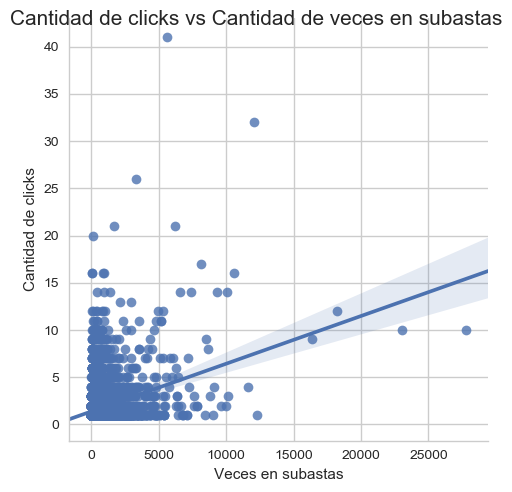

In [26]:
plotDeRelacion= sns.lmplot("Veces en subastas", "Cantidad de clicks", data= clickeadoresDeSubastas)
relacion= plotDeRelacion.fig
relacion.suptitle("Cantidad de clicks vs Cantidad de veces en subastas", fontsize=15)
plt.show()

Del gráfico puede verse que el hecho de que un usuario aparezca muchas veces en una subasta no implica que vaya a hacer muchos clicks. Aunque el gráfico tenga tendencia alcista, hay que pensar en no saturar al usuario.

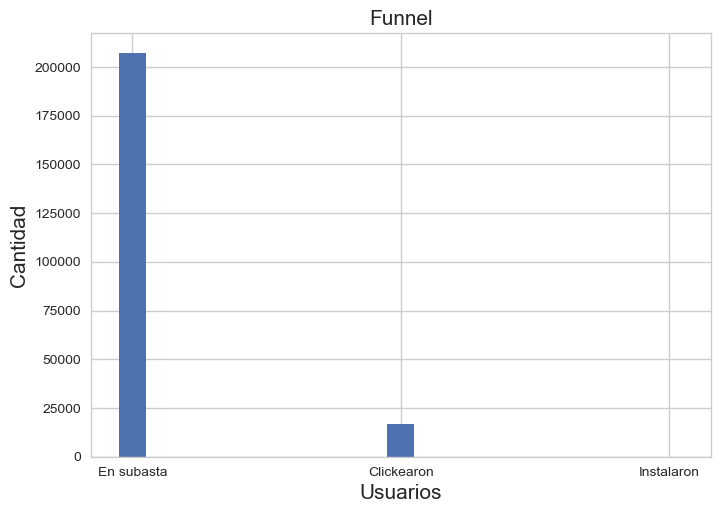

In [28]:
#Algoritmo basado en https://numython.github.io/posts/2016/02/graficas-de-barras-en-matplotlib/

fig = plt.figure() # Figure
grafico = fig.add_subplot(111)

nombres = ['En subasta','Clickearon','Instalaron']
datos = [cantidadDeUsuariosSubastados,cantidadDeUsuariosSubastadosQueClickearon,cantidadDeInstaladoresQueClickearonDesdeSubasta]
ejeY = range(len(datos))

grafico.bar(ejeY, datos, width=0.1, align='center')
grafico.set_xticks(ejeY)
grafico.set_xticklabels(nombres)
grafico.set_xlabel("Usuarios", fontsize=15)
grafico.set_ylabel("Cantidad", fontsize=15)
grafico.set_title("Funnel", fontsize=15)


plt.show()

Del gráfico puede verse que de los usuarios que entraron a la subasta, aproximadamente el %8 pasó al siguiente paso de clickear en la imagen. Se puede aproximar una pérdida del %90 de los usuarios que entran a la subasta para que hagan click. Esto es lógico, ya que no siempre entramos a todas las publicidades que nos muestran.
En cuanto a las instalaciones, fueron 7. Si bien parece infinitamente poco comparado con la cantidad de usuarios que entraron a subastas, tenemos que preguntarnos: ¿Cuántas veces instalamos una aplicacion a partir de una publicidad?

In [30]:
#Veo los usuarios que más instalaron, y analizo los primeros

In [44]:
usuariosInstaladores.sort_values(ascending= False).head()

device_id
5208834946313176321    4
3272750442824629569    4
2515049144505739996    3
4587898421740190562    3
1826618012885478111    3
Name: cantidad, dtype: int64

In [36]:
usuario1= instalaciones[(instalaciones['device_id']== 5208834946313176321)]
usuario1

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
116,2019-03-11 22:39:08.026,2,1891515180541284343,nan,False,True,6333597102633388268,"2,208,834,667,126,999,296.00","2,510,073,341,215,328,768.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.1; XT1033 Bu...,b7f9180c-fdf2-4206-a3b5-b8313cb9f688,open,True,NaN,2706357072127963511,"9,028,382,655,101,200,384.00",5208834946313176321
119,2019-03-11 22:39:42.291,2,1891515180541284343,nan,False,False,6333597102633388268,"2,208,834,667,126,999,296.00","2,510,073,341,215,328,768.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.1; XT1033 Bu...,NaN,NaN,True,NaN,2706357072127963511,"9,028,382,655,101,200,384.00",5208834946313176321
3105,2019-03-12 00:23:46.334,10,1891515180541284343,nan,False,False,6333597102633388268,"2,208,834,667,126,999,296.00","2,510,073,341,215,328,768.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.1; XT1033 Bu...,NaN,NaN,True,NaN,2706357072127963511,"9,028,382,655,101,200,384.00",5208834946313176321
3106,2019-03-12 00:23:18.016,10,1891515180541284343,nan,False,True,6333597102633388268,"2,208,834,667,126,999,296.00","2,510,073,341,215,328,768.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.1; XT1033 Bu...,a91f1999-74b9-400f-babd-ac81da4b6f93,af_app_opened,True,NaN,2706357072127963511,"9,028,382,655,101,200,384.00",5208834946313176321


In [37]:
usuario2= instalaciones[(instalaciones['device_id']== 3272750442824629569)]
usuario2

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
886,2019-03-05 17:05:49.670,2,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","7,116,343,100,936,340,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-J500...,NaN,NaN,True,NaN,2394721645995561079,"9,028,382,655,101,200,384.00",3272750442824629569
887,2019-03-05 17:05:53.778,2,1891515180541284343,nan,False,True,6333597102633388268,"308,305,860,557,778,688.00","7,116,343,100,936,340,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-J500...,bd305ce7-9a75-42a2-95af-c60212617aa4,open,True,NaN,2394721645995561079,"9,028,382,655,101,200,384.00",3272750442824629569
2175,2019-03-05 17:03:33.728,16,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","7,116,343,100,936,340,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-J500...,NaN,NaN,True,NaN,2394721645995561079,"9,028,382,655,101,200,384.00",3272750442824629569
2177,2019-03-05 17:03:26.724,16,1891515180541284343,nan,False,True,6333597102633388268,"308,305,860,557,778,688.00","7,116,343,100,936,340,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-J500...,6e1ab64f-416d-44ec-b057-7c39de87b1bb,af_app_opened,True,NaN,2394721645995561079,"9,028,382,655,101,200,384.00",3272750442824629569


In [38]:
usuario3= instalaciones[(instalaciones['device_id']== 2515049144505739996)]
usuario3

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
479,2019-03-05 22:50:40.354,9,1494519392962156891,nan,False,False,6333597102633388268,nan,"2,331,946,610,914,169,856.00",http-kit/2.0,MercadoPago/2.57.0.2 CFNetwork/976 Darwin/18.2.0,NaN,NaN,True,NaN,2929244200211679186,"369,578,704,436,051,904.00",2515049144505739996
638,2019-03-07 00:12:23.033,9,1494519392962156891,nan,False,False,6333597102633388268,nan,"2,331,946,610,914,169,856.00",http-kit/2.0,MercadoPago/2.58.0.2 CFNetwork/976 Darwin/18.2.0,NaN,NaN,True,NaN,7077955573277489196,"369,578,704,436,051,904.00",2515049144505739996
1417,2019-03-12 20:56:24.485,9,1494519392962156891,nan,False,False,6333597102633388268,nan,"2,331,946,610,914,169,856.00",http-kit/2.0,MercadoPago/2.59.0.1 CFNetwork/976 Darwin/18.2.0,NaN,NaN,True,NaN,36516961177324622,"369,578,704,436,051,904.00",2515049144505739996


In [39]:
usuario4= instalaciones[(instalaciones['device_id']== 4587898421740190562)]
usuario4

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
3117,2019-03-12 04:13:55.951,10,1891515180541284343,nan,False,False,6333597102633388268,"2,208,834,667,126,999,296.00","4,801,466,693,533,143,040.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0; MotoG3 Bu...,NaN,NaN,True,NaN,2403839579048525602,"9,028,382,655,101,200,384.00",4587898421740190562
3220,2019-03-12 04:15:54.813,16,1891515180541284343,nan,False,True,6333597102633388268,"2,208,834,667,126,999,296.00","4,801,466,693,533,143,040.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0; MotoG3 Bu...,434bdac7-014d-4d7b-8020-f8f1e020b2f9,af_app_opened,True,NaN,2403839579048525602,"9,028,382,655,101,200,384.00",4587898421740190562
3221,2019-03-12 04:15:50.824,16,1891515180541284343,nan,False,False,6333597102633388268,"2,208,834,667,126,999,296.00","4,801,466,693,533,143,040.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0; MotoG3 Bu...,NaN,NaN,True,NaN,2403839579048525602,"9,028,382,655,101,200,384.00",4587898421740190562


In [40]:
usuario5= instalaciones[(instalaciones['device_id']== 1826618012885478111)]
usuario5

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
208,2019-03-05 19:11:47.218,8,1494519392962156891,nan,False,False,2970470518450881158,nan,"9,149,036,486,232,460,288.00",adjust.com,NaN,NaN,NaN,NaN,NaN,317237346526952711,"3,301,377,775,977,699,840.00",1826618012885478111
397,2019-03-08 14:46:10.207,9,1494519392962156891,nan,False,False,6333597102633388268,nan,"2,331,946,610,914,169,856.00",http-kit/2.0,MercadoPago/2.58.0.2 CFNetwork/976 Darwin/18.2.0,NaN,NaN,True,NaN,963946070348102922,"4,621,024,053,086,952,448.00",1826618012885478111
398,2019-03-08 14:46:10.023,9,1494519392962156891,nan,False,True,6333597102633388268,nan,"2,331,946,610,914,169,856.00",http-kit/2.0,MercadoPago/2.58.0.2 CFNetwork/976 Darwin/18.2.0,f0183108-1e25-4862-ba46-73db95cbcc0c,af_app_opened,True,NaN,963946070348102922,"4,621,024,053,086,952,448.00",1826618012885478111


Algunas observaciones por demás extrañas: algunas aplicaciones aparecen duplicadas con segundos (o incluso microsegundos) de diferencia. Pero llama la atención el usuario 3 (device id 2515049144505739996), quien instaló la aplicación 9 tres veces en días distintos. ¿Por qué alguien instalaría y desinstalaría la aplicación en días distintos?

In [43]:
instalaciones['cantidadDeAplicacionesInstaladas']= instalaciones['application_id'].map(lambda x: 1)
aplicacionesInstaladas= instalaciones.groupby('application_id')['cantidadDeAplicacionesInstaladas'].sum()
del instalaciones['cantidadDeAplicacionesInstaladas']

aplicacionesInstaladas.sort_values(ascending= False).head()

application_id
7     947
9     731
10    389
16    362
8     328
Name: cantidadDeAplicacionesInstaladas, dtype: int64

In [57]:
instalaciones['probandoIP']= instalaciones['ip_address'].map(lambda x: 1)
IPs= instalaciones.groupby('ip_address')['probandoIP'].sum()
del instalaciones['probandoIP']

IPmasUsadas= IPs.sort_values(ascending= False).head(10)
IPmasUsadas

ip_address
1992632945768888579    33
2403839579048525602    26
2394721645995561079    17
589886713227299026     16
8262991154202232888    14
8010533080341024188    13
7726314782926052608    12
8531002764348621869    12
2441645233986204328    11
7481987231813232849    11
Name: probandoIP, dtype: int64

In [46]:
instalaciones[(instalaciones['ip_address']==1992632945768888579)]

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,device_id
58,2019-03-10 17:37:11.998,2,1891515180541284343,nan,False,False,6333597102633388268,"4,371,307,750,970,992,640.00","728,615,636,961,504,128.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 7.0; Lenovo K3...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",5487018566680760822
59,2019-03-10 00:27:11.131,2,1891515180541284343,nan,False,True,6333597102633388268,"2,208,834,667,126,999,296.00","8,240,213,334,643,959,808.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.0.0; Moto Z2...,78838e65-8a9f-4644-a72a-e3866f6775a5,open,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",4256346209371278943
63,2019-03-10 14:38:05.464,2,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","5,960,895,846,746,644,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.0.0; SM-G935...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",4012743072911938567
64,2019-03-10 14:36:55.733,2,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","3,285,184,267,429,729,280.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 7.0; SM-G928G ...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",5944703426070771098
66,2019-03-10 14:54:02.648,2,1891515180541284343,nan,False,False,6333597102633388268,"513,799,204,676,421,248.00","3,394,346,736,352,182,272.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.0.2; Redmi N...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",5129780403184854828
67,2019-03-10 14:51:43.261,2,1891515180541284343,nan,False,True,6333597102633388268,"513,799,204,676,421,248.00","3,394,346,736,352,182,272.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.0.2; Redmi N...,0c8f0c41-6ad5-41fd-828c-2f69dc227438,open,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",5129780403184854828
102,2019-03-12 15:11:07.895,2,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","9,098,443,153,716,766,720.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G532...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",482100949468188443
868,2019-03-07 14:22:57.039,2,1891515180541284343,nan,False,False,6333597102633388268,"308,305,860,557,778,688.00","7,116,343,100,936,340,480.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-J500...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",3302086933387973849
877,2019-03-07 23:01:03.085,2,1891515180541284343,nan,False,True,6333597102633388268,"2,208,834,667,126,999,296.00","8,240,213,334,643,959,808.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.0.0; Moto Z2...,da52d2da-c454-4b10-b84a-f863c07e877f,open,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",7054149360879771998
897,2019-03-08 01:17:16.593,2,1891515180541284343,nan,False,False,6333597102633388268,"2,208,834,667,126,999,296.00","2,510,073,341,215,328,768.00",http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 5.1; XT1033 Bu...,NaN,NaN,True,NaN,1992632945768888579,"9,028,382,655,101,200,384.00",8670028190594846665


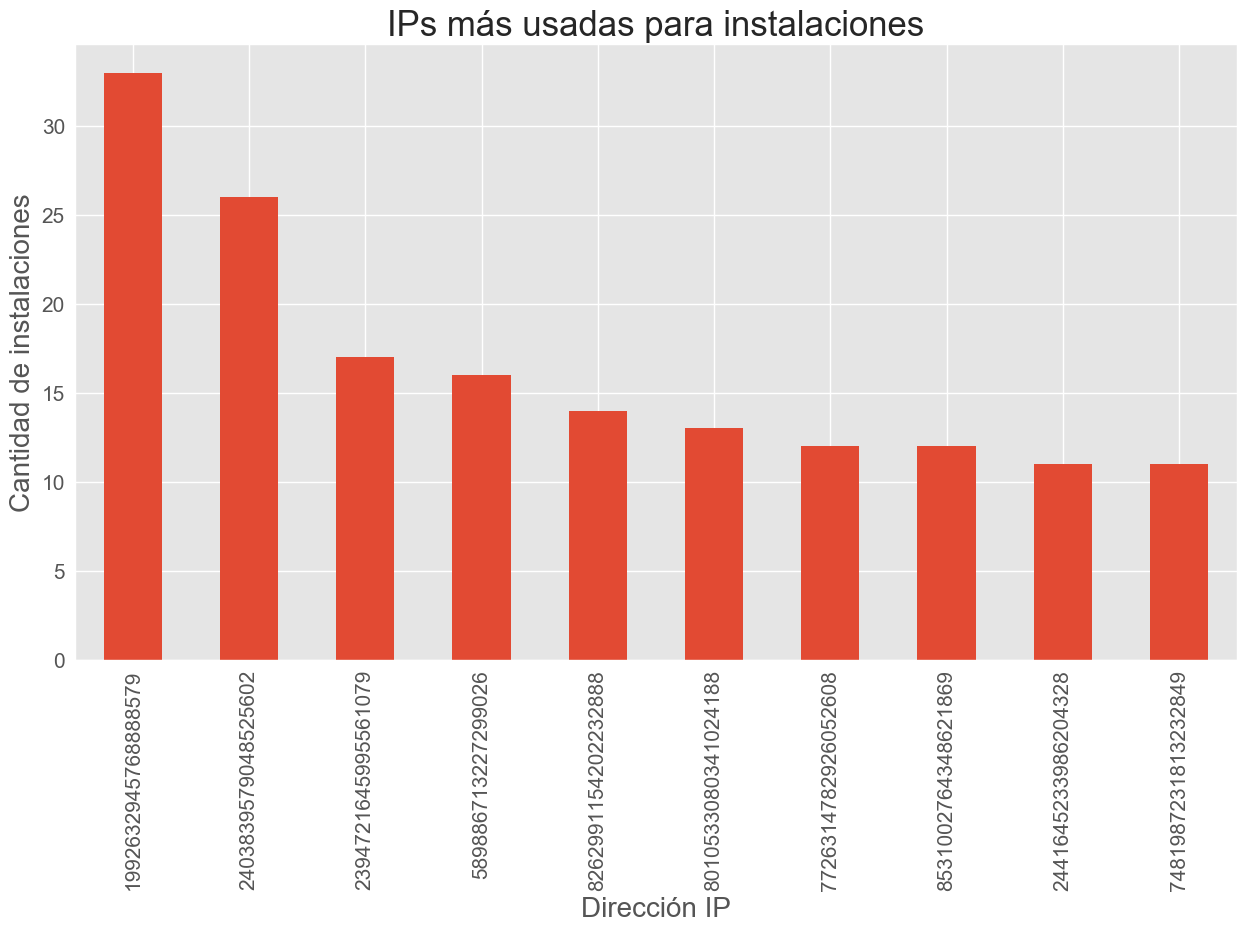

In [108]:
grafico= IPmasUsadas.plot.bar(fontsize= 15)
grafico.set_xlabel("Dirección IP", fontsize=20)
grafico.set_ylabel("Cantidad de instalaciones", fontsize=20)
grafico.set_title("IPs más usadas para instalaciones", fontsize=25)

plt.show()

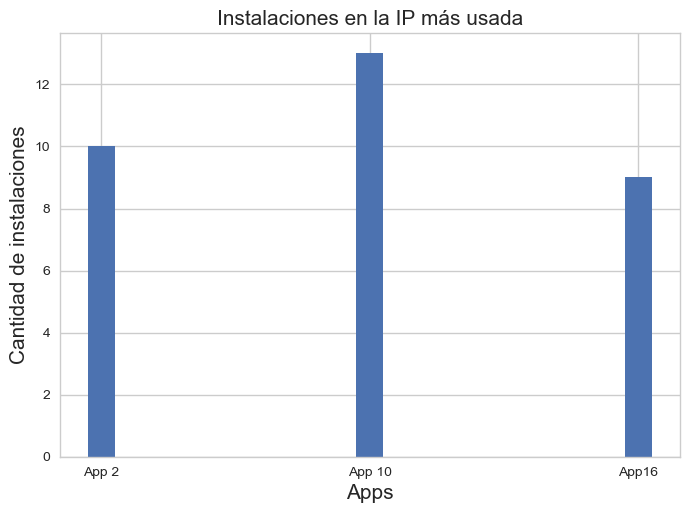

In [49]:
#Algoritmo basado en https://numython.github.io/posts/2016/02/graficas-de-barras-en-matplotlib/

fig = plt.figure() # Figure
grafico = fig.add_subplot(111)

nombres = ['App 2','App 10','App16']
datos = [10,13,9]
ejeY = range(len(datos))

grafico.bar(ejeY, datos, width=0.1, align='center')
grafico.set_xticks(ejeY)
grafico.set_xticklabels(nombres)
grafico.set_xlabel("Apps", fontsize=15)
grafico.set_ylabel("Cantidad de instalaciones", fontsize=15)
grafico.set_title("Instalaciones en la IP más usada", fontsize=15)


plt.show()

In [83]:
instalaciones['sumandoFechas']= pd.to_datetime(instalaciones['created']).dt.date.map(lambda x: 1)
fechasInstalaciones= instalaciones.groupby(pd.to_datetime(instalaciones['created']).dt.date)['sumandoFechas'].sum()
del instalaciones['sumandoFechas']

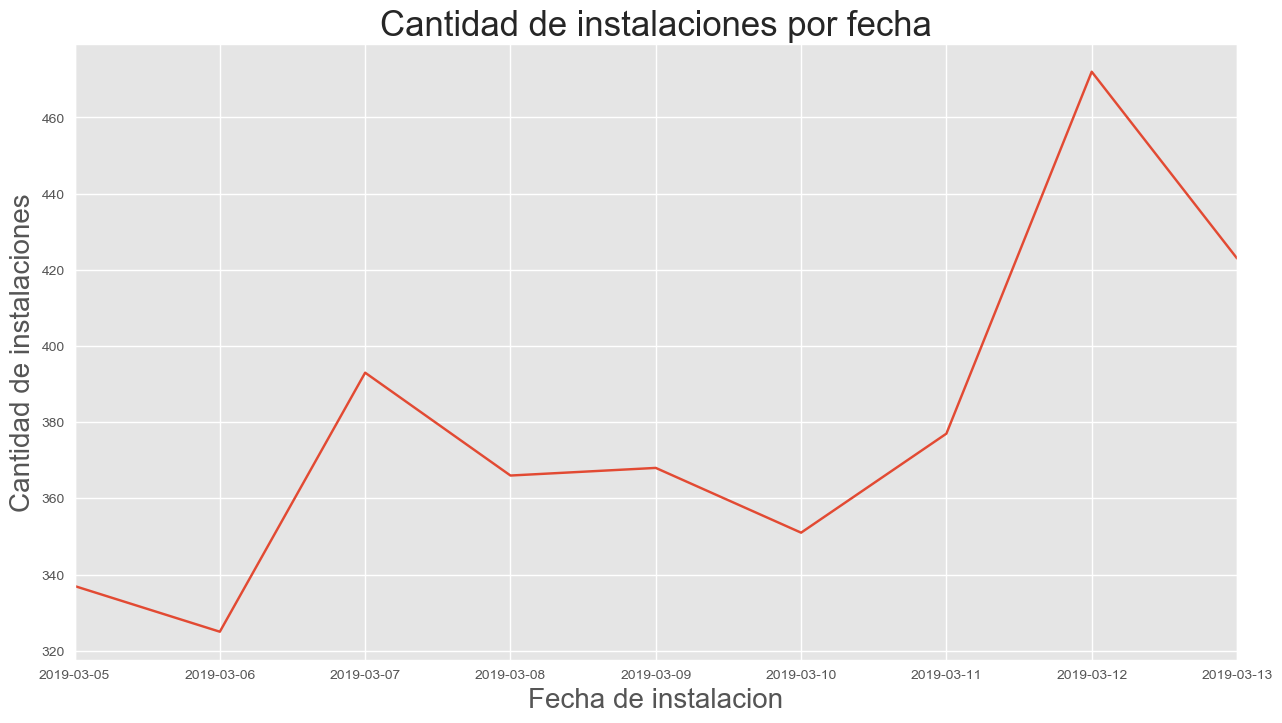

In [84]:
grafico= fechasInstalaciones.plot.line()
grafico.set_xlabel("Fecha de instalacion", fontsize=20)
grafico.set_ylabel("Cantidad de instalaciones", fontsize=20)
grafico.set_title("Cantidad de instalaciones por fecha", fontsize=25)

plt.show()

In [86]:
subastas['sumandoFechas']= pd.to_datetime(subastas['date']).dt.date.map(lambda x: 1)
fechasSubastados= subastas.groupby(pd.to_datetime(subastas['date']).dt.date)['sumandoFechas'].sum()
del subastas['sumandoFechas']

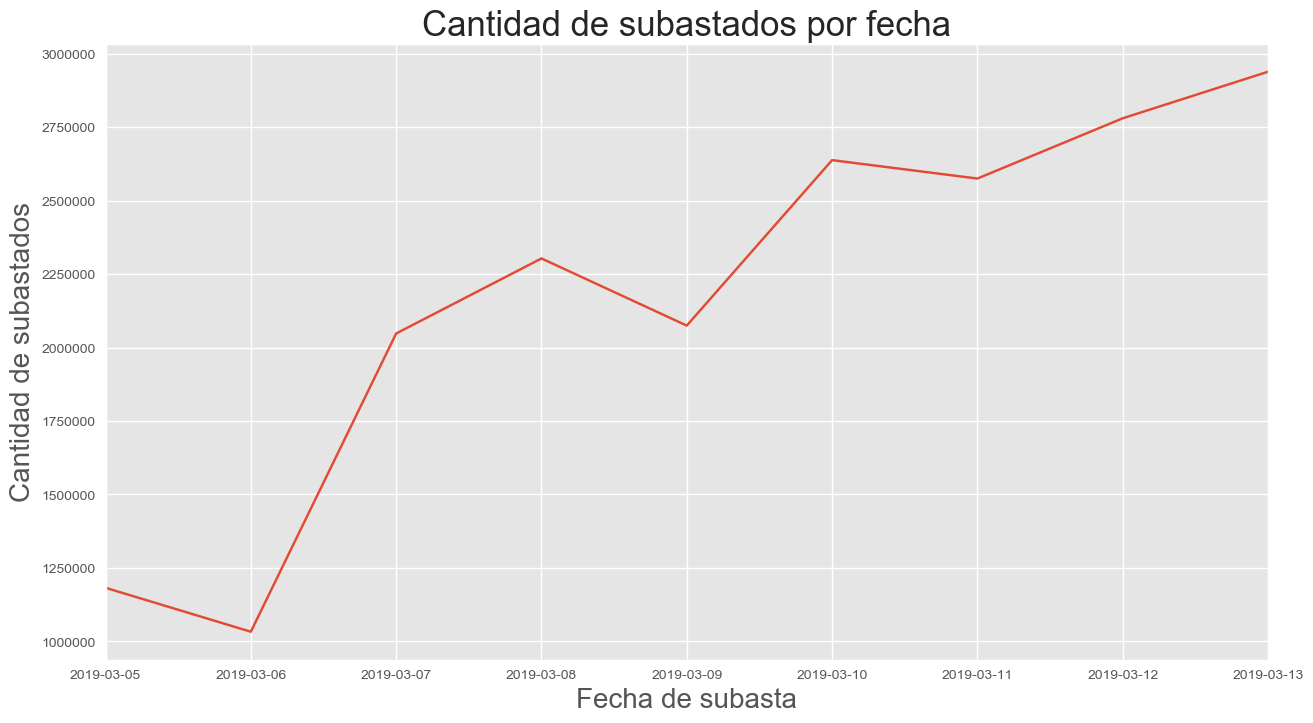

In [87]:
grafico= fechasSubastados.plot.line()
grafico.set_xlabel("Fecha de subasta", fontsize=20)
grafico.set_ylabel("Cantidad de subastados", fontsize=20)
grafico.set_title("Cantidad de subastados por fecha", fontsize=25)

plt.show()

In [94]:
clicks['sumandoFechas']= pd.to_datetime(clicks['created']).dt.date.map(lambda x: 1)
fechasClicks= clicks.groupby(pd.to_datetime(clicks['created']).dt.date)['sumandoFechas'].sum()
del clicks['sumandoFechas']

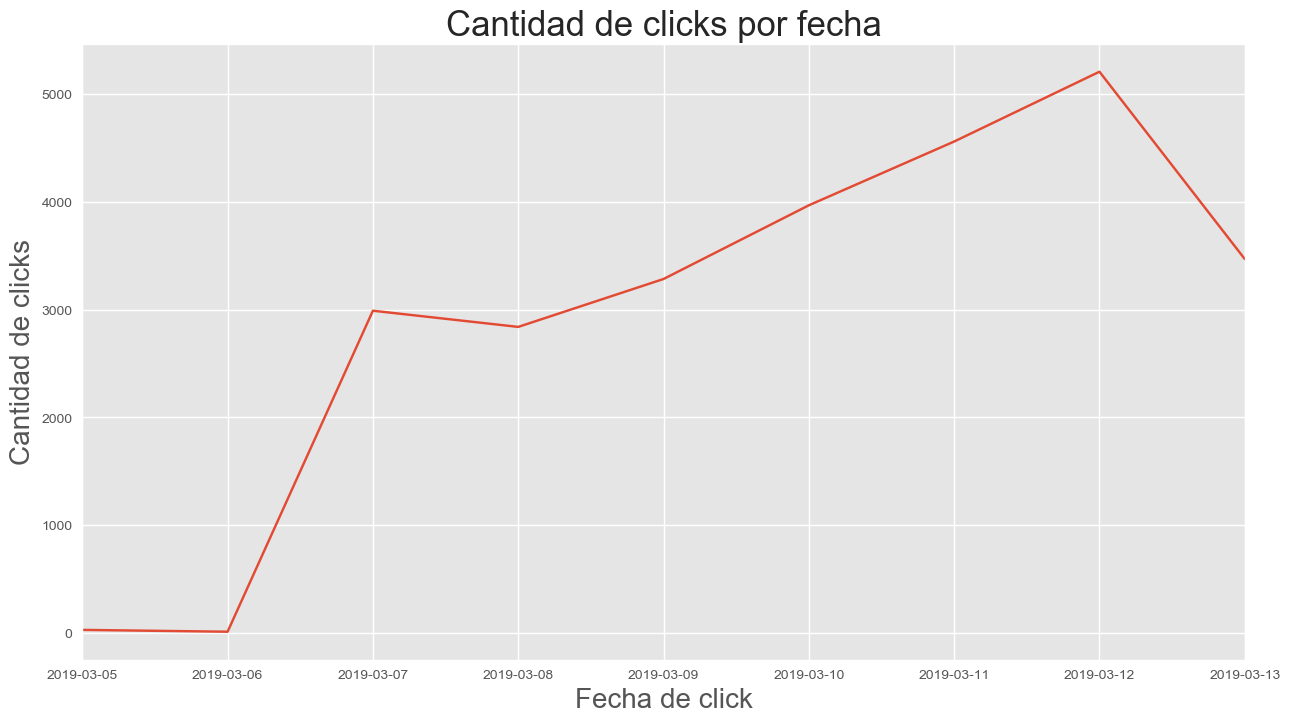

In [95]:
grafico= fechasClicks.plot.line()
grafico.set_xlabel("Fecha de click", fontsize=20)
grafico.set_ylabel("Cantidad de clicks", fontsize=20)
grafico.set_title("Cantidad de clicks por fecha", fontsize=25)

plt.show()

De los graficos puede verse que el mejor día para subastas, clicks e instalaciones fue el martes 12 de Marzo. También puede verse una conclusión anterior: no por haber muchas subastas tiene que haber muchos clicks o instalaciones. El dia con mayor cantidad de subastas fue el miércoles 13 de Marzo, y ese día con respecto al anterior hubo una caída de clicks e instalaciones. Además, el domingo 10 de Marzo fue uno de los días con mayor cantidad de subastas, y al mismo tiempo uno de los de menor cantidad de instalaciones.

In [ ]:
#Analizo el comportamiento de los usuarios que más entraron a subasta

In [38]:
subastas['sumandoUsuarios']= subastas['device_id'].map(lambda x: 1)
usuarios= subastas.groupby('device_id')['sumandoUsuarios'].sum()
del subastas['sumandoUsuarios']

usuarios.sort_values(ascending= False).head()

device_id
633139769114048761     27762
7202276635029175071    23055
7298861376107043945    18188
6302840482782120473    16400
5376802567578262905    16367
Name: sumandoUsuarios, dtype: int64

In [19]:
usuarioSubastado1= subastas[(subastas['device_id']== 633139769114048761)]
usuarioSubastado1['sumandoFechas']= pd.to_datetime(usuarioSubastado1['date']).dt.date.map(lambda x: 1)
fechaSubastado1= usuarioSubastado1.groupby(pd.to_datetime(usuarioSubastado1['date']).dt.date)['sumandoFechas'].sum()
del usuarioSubastado1['sumandoFechas']

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
usuarioSubastado2= subastas[(subastas['device_id']== 7202276635029175071)]
usuarioSubastado2['sumandoFechas']= pd.to_datetime(usuarioSubastado2['date']).dt.date.map(lambda x: 1)
fechaSubastado2= usuarioSubastado2.groupby(pd.to_datetime(usuarioSubastado2['date']).dt.date)['sumandoFechas'].sum()
del usuarioSubastado2['sumandoFechas']

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
usuarioSubastado3= subastas[(subastas['device_id']== 7298861376107043945)]
usuarioSubastado3['sumandoFechas']= pd.to_datetime(usuarioSubastado3['date']).dt.date.map(lambda x: 1)
fechaSubastado3= usuarioSubastado3.groupby(pd.to_datetime(usuarioSubastado3['date']).dt.date)['sumandoFechas'].sum()
del usuarioSubastado3['sumandoFechas']

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
usuarioSubastado4= subastas[(subastas['device_id']== 6302840482782120473)]
usuarioSubastado4['sumandoFechas']= pd.to_datetime(usuarioSubastado4['date']).dt.date.map(lambda x: 1)
fechaSubastado4= usuarioSubastado4.groupby(pd.to_datetime(usuarioSubastado4['date']).dt.date)['sumandoFechas'].sum()
del usuarioSubastado4['sumandoFechas']

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [23]:
usuarioSubastado5= subastas[(subastas['device_id']== 5376802567578262905)]
usuarioSubastado5['sumandoFechas']= pd.to_datetime(usuarioSubastado5['date']).dt.date.map(lambda x: 1)
fechaSubastado5= usuarioSubastado5.groupby(pd.to_datetime(usuarioSubastado5['date']).dt.date)['sumandoFechas'].sum()
del usuarioSubastado5['sumandoFechas']

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


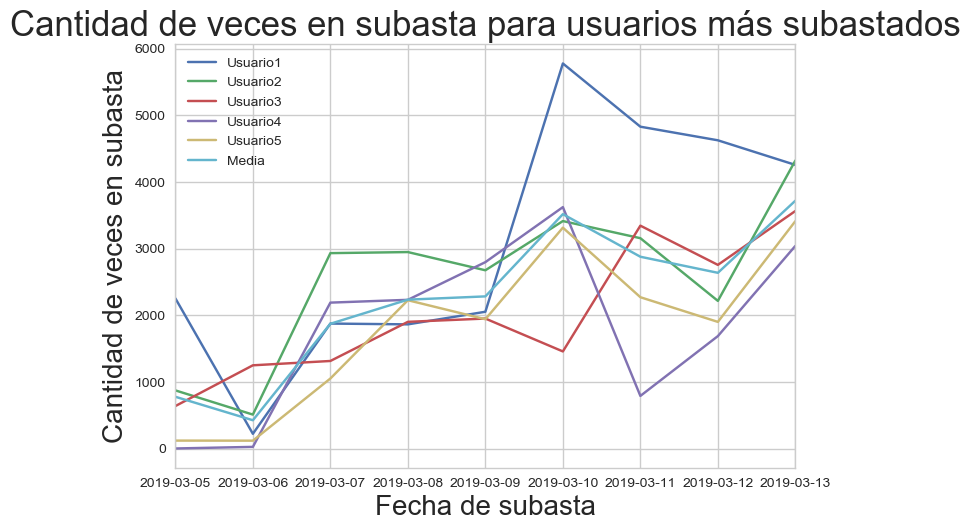

In [34]:
media= (fechaSubastado1+ fechaSubastado2+ fechaSubastado3+ fechaSubastado4+ fechaSubastado5)/5
usuarios = pd.DataFrame({'Usuario1': fechaSubastado1,'Usuario2': fechaSubastado2,'Usuario3': fechaSubastado3,'Usuario4': fechaSubastado4,'Usuario5': fechaSubastado5,'Media': media})

grafico= usuarios.plot.line()
grafico.set_xlabel("Fecha de subasta", fontsize=20)
grafico.set_ylabel("Cantidad de veces en subasta", fontsize=20)
grafico.set_title("Cantidad de veces en subasta para usuarios más subastados", fontsize=25)

plt.show()

Si bien el comportamiento de los usuarios es aleatorio, puede observarse que la media sigue la curva del gráfico de subastas.